

# Implementation of a cascade of regressions for facial landmarks localisation

## Authors: Arnaud Dapogny, Kévin Bailly

Léo Porte : 21200044
Hugo Riffaud de Turckheim: 3800256
    
Tout le code est disponible dans le repertoire ./utils

## Introduction

In the context of this project, we propose to estimate the position of facial landmarks from a photograph. Our approach is divided into several key steps:

    Data Preparation: We have a set of facial images accompanied by their respective landmarks. However, these images vary in size and centering. To standardize our database, we will adjust the faces to be centered and uniformize the dimensions of the images, bringing them all to a 128x128 pixel format.

    Creation of the Average Face: We will train a linear regression model to learn to adjust the landmarks of an average face – a synthetic representation obtained from our database – so that they match the landmarks of a specific face. This process involves solving a linear system, where we aim to superimpose the average face and the necessary landmark displacements to adapt to a particular face. To improve this approach, we will incorporate scale and translation deformations to the average face, thus increasing the robustness of our regression.

    Dimensionality Reduction: The images in our database contain a significant amount of information, some of which are not essential for our study and could unnecessarily complicate the learning process. To optimize our calculations, we will employ two dimensionality reduction techniques. First, the SIFT algorithm will be used to refine the features of each image. Then, we will apply Principal Component Analysis (PCA). Although linear, PCA is an effective and relatively simple method to implement.

    Training the Linear Regression Model: Using the data refined by the SIFT and PCA techniques, as well as the modified average faces, we will be able to train a linear regression model. This final method aims to accurately predict the displacement of landmarks for a given face, based on our processed and standardized dataset.

The entire approach aims to develop a robust and efficient model, capable of accurately processing a variety of faces, while taking into account the specificities and constraints of our database.

### Imports

In [ ]:
import zipfile
import os
from random import sample
import numpy as np
import cv2
import matplotlib.pyplot as plt
from  sklearn.decomposition import PCA as sk_PCA
from sklearn.linear_model import LinearRegression

from utils import*

# Data preprocessing

## Data download

In [ ]:
#!wget https://cloud.isir.upmc.fr/s/WMiMAF4aQqjoZWe/download/300w.zip

Extract files from zip

In [ ]:
with zipfile.ZipFile("300w.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

Read 300w_train_images.txt and 300w_train_landmarks.txt and extract values in a list

In [ ]:
with open("300w_train_images.txt", "r") as f:
    train_images = np.array(f.read().splitlines())

with open("300w_train_landmarks.txt", "r") as f:
    train_landmarks = np.array(f.read().splitlines())

with open("lfpw_testset.txt", "r") as f:
    test_images = np.array(f.read().splitlines())

with open("lfpw_testset_landmarks.txt", "r") as f:
    test_landmarks = np.array(f.read().splitlines())

## Data visualization

Define 12 random numbers to determine images to show

In [ ]:
indices = sample(range(len(train_images)), 12)

im_to_show = train_images
lm_to_show = train_landmarks

Display images

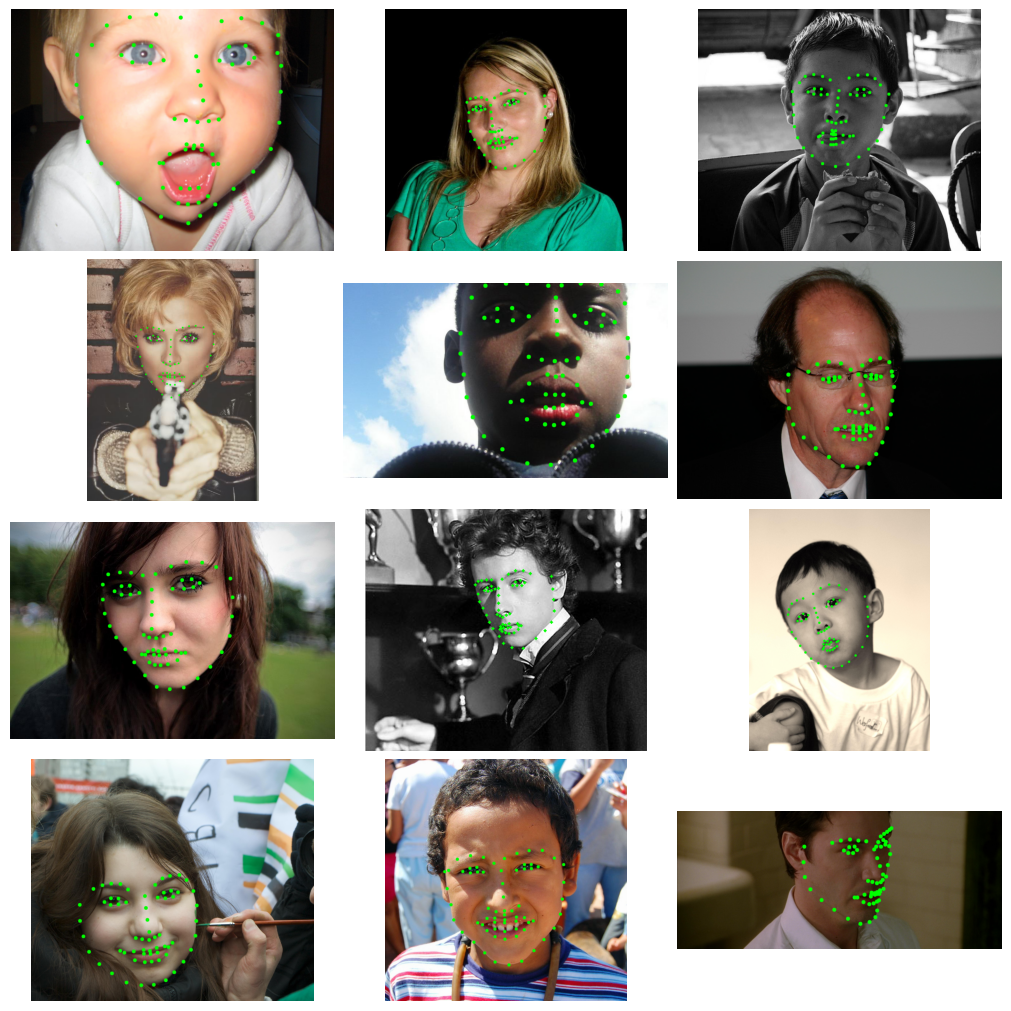

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(10, 10), layout='constrained')

cpt_show=0
for i in range(im_to_show.size):

    image = cv2.imread(im_to_show[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    landmarks = read_landmarks(lm_to_show[i])
    draw_landmarks(image, landmarks)
    if i in indices:
        axs[int(cpt_show%4)][int(cpt_show%3)].imshow(image)
        axs[int(cpt_show%4)][int(cpt_show%3)].axis("off")
        cpt_show+=1


## Data augmentation

### Compute the parameters of the bounding box of facial landmarks

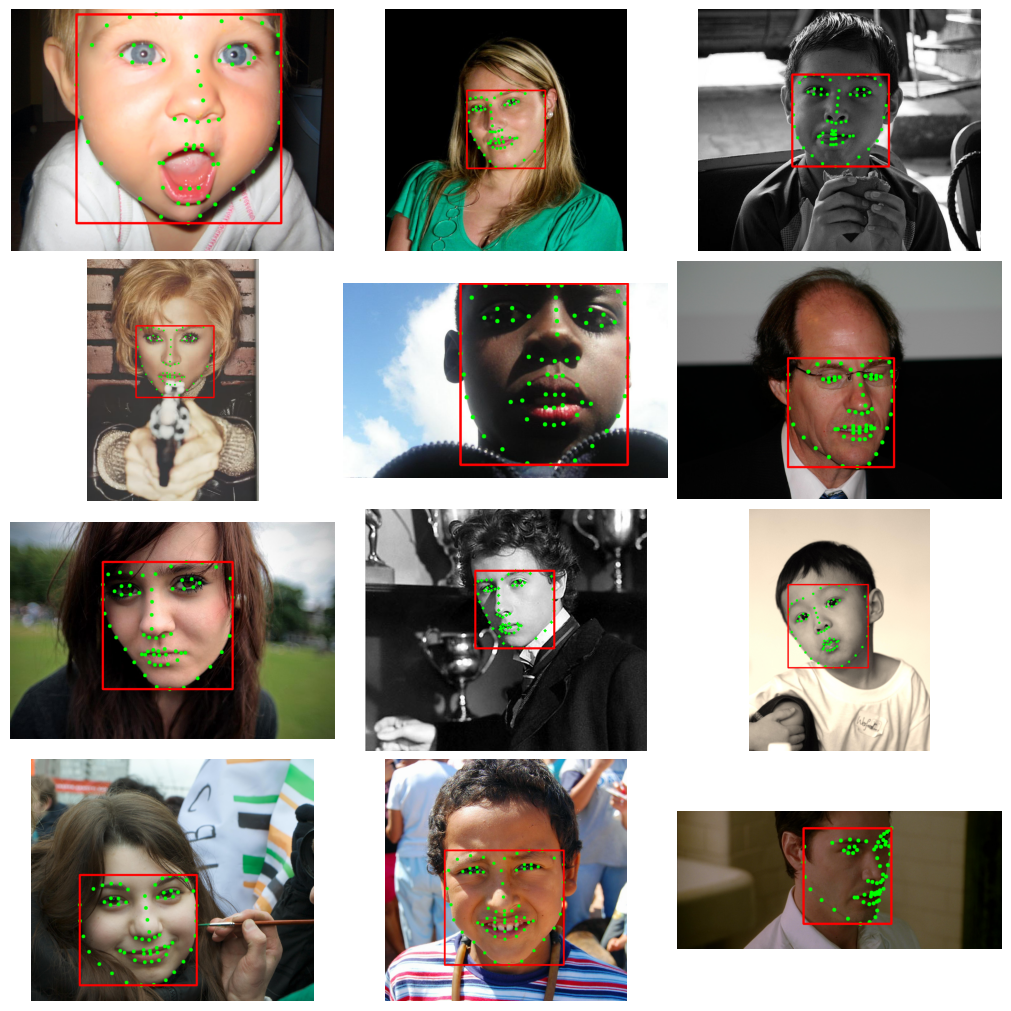

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(10, 10), layout='constrained')

cpt_show=0
for i in range(im_to_show.size):

    image = cv2.imread(im_to_show[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    landmarks = read_landmarks(lm_to_show[i])
    draw_landmarks(image, landmarks)
    draw_bounding_box(image, landmarks)
    if i in indices:
        axs[int(cpt_show%4)][int(cpt_show%3)].imshow(image)
        axs[int(cpt_show%4)][int(cpt_show%3)].axis("off")
        cpt_show+=1

### Widen this bounding box by 30 %, crop the image with these new dimensions, and resize the image in 128 ∗ 128 and save it on the disk

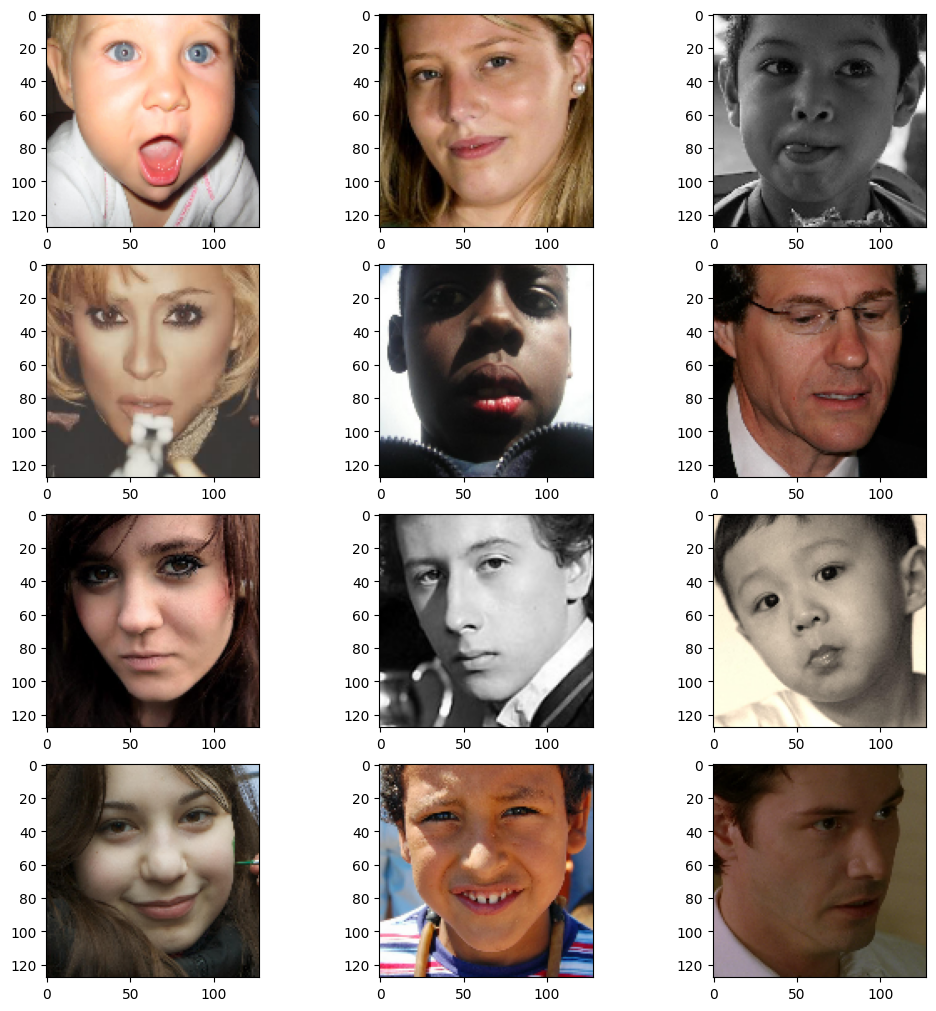

In [ ]:
if not os.path.isdir("content"):
    os.mkdir("content")

if not os.path.isdir("content/train_images"):
    os.mkdir("./content/train_images")

crop_resize_save(im_to_show,lm_to_show,idxs_show=indices,path="./content/train_images",plot=True)
crop_resize_save(test_images,test_landmarks,idxs_show=indices,path="./content/test_images")
update_lm(test_images,test_landmarks,indices,path="test_images",plot=False)

### Compute the new landmarks coordinates for this resized image. This new position is the ground truth.

In [ ]:
update_lm(im_to_show,lm_to_show,idxs_show=indices)

### Compute the mean position of each landmark on the training set. It constitutes the mean shape of the face.

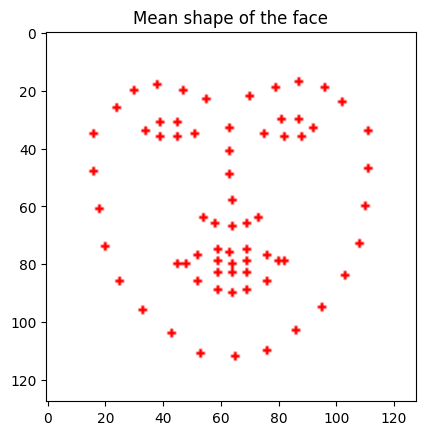

In [ ]:
# Specify the path to your training data folder
training_data_folder = "./content/train_images"

# Compute the mean shape of the face
mean_shape,_ = compute_mean_shape(training_data_folder,plot=True)

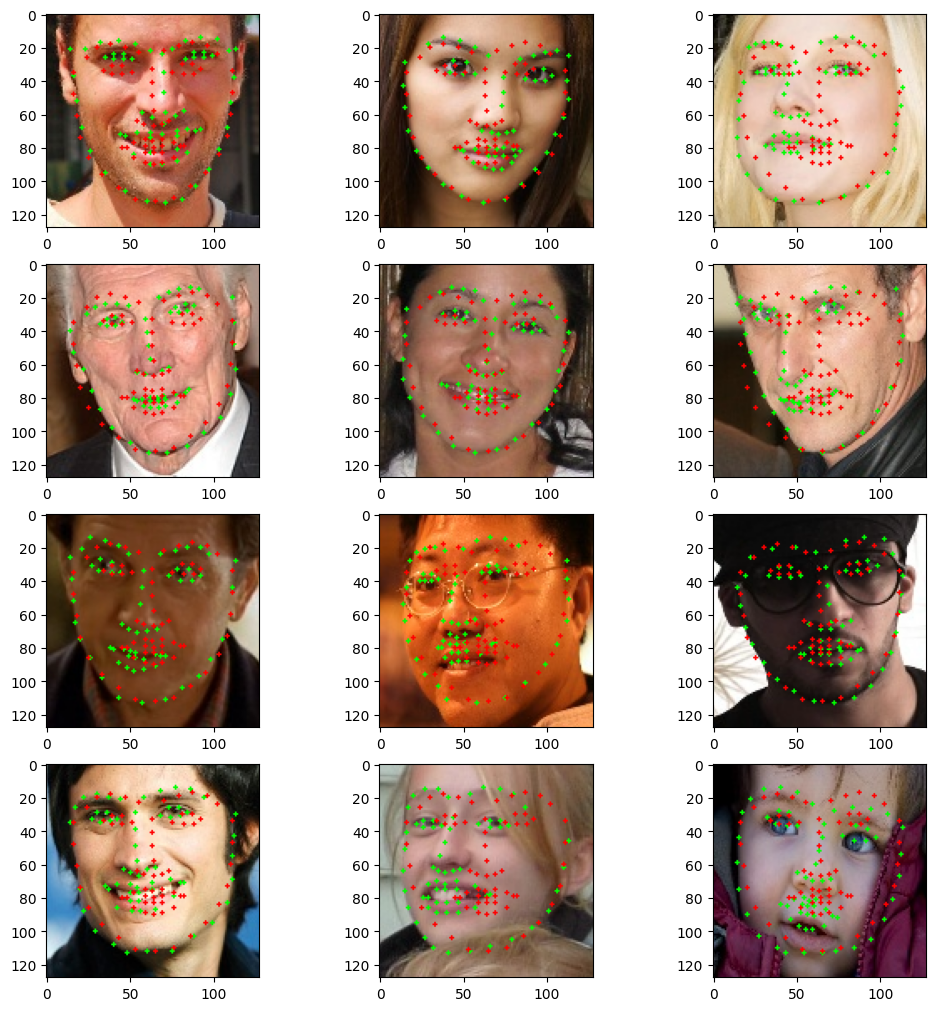

In [ ]:
draw_mean_on_faces(training_data_folder,mean_shape,idxs_show=indices)

### Initialize the mean shape in each image and generate 10 random perturbations (in translation and scaling) around this position. The amplitude of these perturbations will be ±20% and ±20px for scaling and translation respectively.

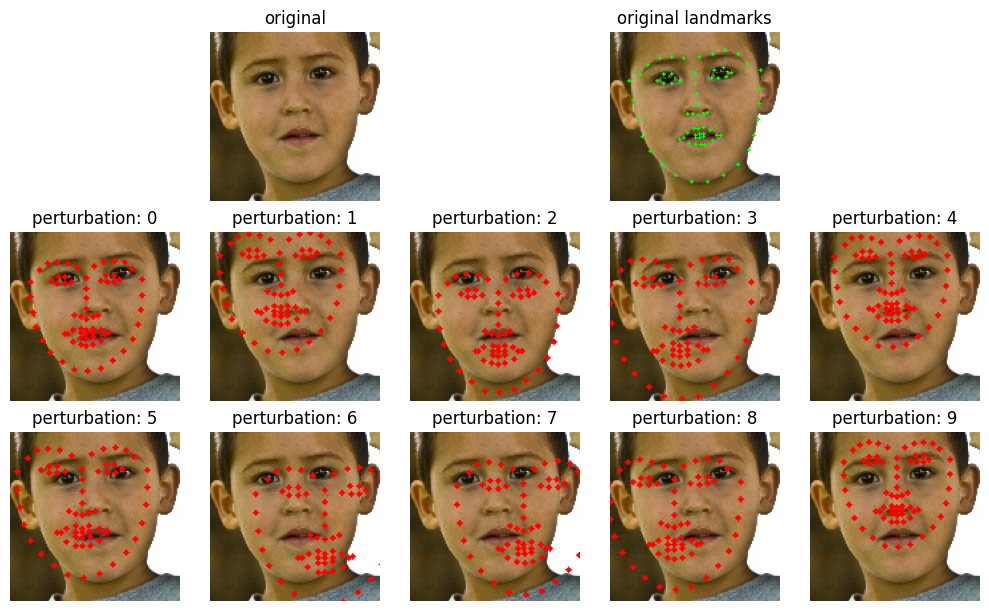

In [ ]:
# Specify the path to your training data folder
training_data_folder = "./content/train_images"

# Compute the mean shape of the face
mean_shape,_ = compute_mean_shape(training_data_folder,plot=False)

# Choose an example image from the training set
example_image_path = os.path.join(training_data_folder, "resized_image_11.jpg")

# Initialize the mean shape and generate perturbations for the example image
example_image, example_landmarks, perturbations = initialize_and_perturbate(example_image_path, mean_shape)

show_perturbations(example_image, example_landmarks, perturbations)

### Why do we generate these perturbations? How could they be estimated automatically?

By computing an average face landmark we create a standard reference point to train the regressor. We compute those transformations to make our model more robust to small changes between each to each image in our dataset. This is important because in our dataset faces are not centered (which can be seen as a translation) and sometimes the size of faces of the image is different from one to another (ie. scaling).  By using those deformations we hope that the model will be able to generalize better to a more diverse set of images.

Automatic estimation of these perturbations could be approached by leveraging statistical analysis of the training dataset. By analyzing the variance in landmark positions across the dataset, one could derive typical ranges for translation and scaling changes. Machine learning algorithms, particularly those specializing in pattern recognition, could also be used to learn these perturbations from data. This approach would involve training a model on a subset of the data to learn the distribution of landmark positions and then using the model to generate perturbations for new images.

# Traning of a single regressor

## Feature extraction

### Create, for each current landmark of the mean model a cv2.keyPoint object by specifying its coordinates, and setting the size of the surrounding patch to 20px.

Here we created a method that crop the image with a random scaling factor. It helps to have a more diverse dataset.

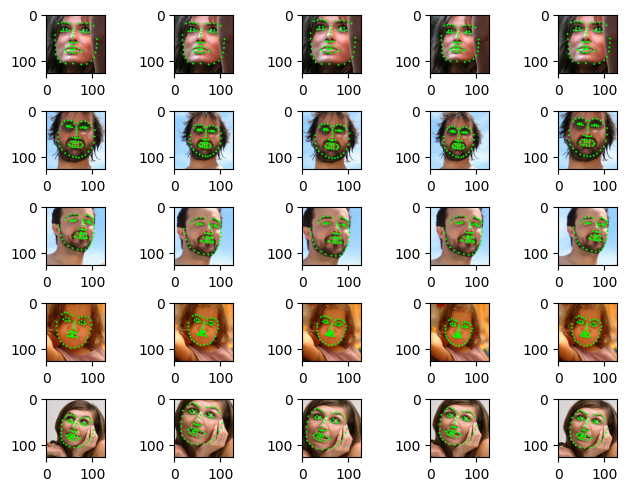

In [ ]:
crop_resize_save_enhanced(im_to_show,lm_to_show,idxs_show=indices,path="/content/improved_images",plot=True)

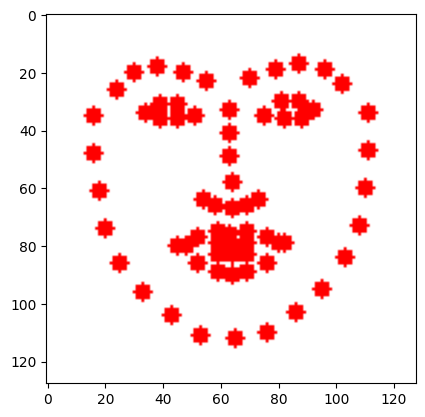

In [ ]:
training_data_folder = "./content/train_images"

# Specify the mean shape of the face
mean_shape,L_train_landmarks = compute_mean_shape(training_data_folder)

# Create cv2.KeyPoint objects for each landmark
keypoints = create_keypoints(mean_shape)

# Visualize the keypoints on an image
image_with_keypoints = np.ones((128, 128, 3), dtype=np.uint8) * 255  # Create a white image for visualization

for keypoint in keypoints:
    x, y = map(int, keypoint.pt)
    cv2.circle(image_with_keypoints, (x, y), 3, (255, 0, 0), -1)  # Draw a red circle at each keypoint

plt.imshow(image_with_keypoints)

### Use the OpenCV sift.compute function to compute a SIFT feature around each landmark.

In [ ]:
# Function to compute SIFT features around each landmark
def compute_sift_features(image, keypoints):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Compute SIFT features for each keypoint
    _, descriptors = sift.compute(gray_image, keypoints)

    return descriptors

# Create cv2.KeyPoint objects for each landmark
mean_shape,_ = compute_mean_shape(training_data_folder)
keypoints = create_keypoints(mean_shape)

# Example image for demonstration purposes
image = np.ones((128, 128, 3), dtype=np.uint8) * 255  # White image for visualization

# Compute SIFT features around each landmark
sift_features = compute_sift_features(image, keypoints)

# Print the shape of the computed SIFT features (descriptor matrix)
print("Shape of SIFT features:", sift_features.shape)

Shape of SIFT features: (68, 128)


### What is the dimension of each feature?

The dimension of each feature is 128. This is a major reduction of dimensions.

### For each image, concatenate all the computed features from each landmarks

In [ ]:
# Specify the path to your dataset
dataset_path = "./content/improved_images"

# Create cv2.KeyPoint objects for each landmark
mean_shape,_ = compute_mean_shape(training_data_folder)
keypoints = create_keypoints(mean_shape)

# Initialize an array to store concatenated features for all images
all_features = []
L_train_landmarks=[]
L_mean_landmarks=[]
# Loop through all images in the dataset
for file_name in os.listdir(dataset_path):
    for _ in range(10):
        if file_name.endswith(".jpg"):
            # Read image and landmarks
            image_path = os.path.join(dataset_path, file_name)
            image = cv2.imread(image_path)
            landmarks_path = image_path.replace('.jpg', '.pts')
            landmarks = read_landmarks(landmarks_path)
            L_train_landmarks.append(landmarks)

            # Compute SIFT features around each landmark
            mean_landmarks=perturbate_meanshape(mean_shape, scale_amplitude=0.2, translation_amplitude=20)
            L_mean_landmarks.append(mean_landmarks)
            keypoints = create_keypoints(mean_landmarks.copy())
            sift_features = compute_sift_features(image, keypoints)

            # Concatenate the features for this image

            concatenated_features = sift_features.flatten()

            # Add the concatenated features to the array
            all_features.append(concatenated_features)


# Convert the array to a numpy array for further processing
all_features = np.array(all_features)
L_mean_landmarks=np.array(L_mean_landmarks)
L_mean_landmarks=L_mean_landmarks.reshape((L_mean_landmarks.shape[0],136))
print(L_mean_landmarks.shape)
# Print the shape of the concatenated features array
print("Shape of X_0:", all_features.shape)

(157400, 136)
Shape of X_0: (157400, 8704)


### What is the dimension of this feature vector?

For each image, the feature vector has a size of 8704.

## Dimensionality reduction

### What is the main interest of this dimensionality reduction? Could you cite some other dimensionality reduction methods for machine learning?

The dimensionality reduction have a lot of benefits:
    
    -isolate good features and get rid of data which is not necessary.
    -Gain in computational costs.
    -denoising abilities.
    -It is also used for data vizualisation.
    
The PCA is linear. Other dimensionality reduction techniques that are not linear exists, such as encoder/decoder deep learning architectures, Linear Discriminant Analysis (LDA) or Isometric Mapping.

### Use the PCA (OpenCV or skimage) to keep 98% of the total variance of the features

In [ ]:
def get_PCA(X):
    pca = sk_PCA(n_components=0.98)
    pca.fit(X)
    return pca

pca=get_PCA(all_features)

reduced_features=pca.transform(all_features)
print(reduced_features.shape)

(157400, 473)


### What are the dimensions of the new resulting matrix $\tilde{X_0}$? TO ANSWER

for each image, the associated features vector has a size of 473.

## Displacement estimation

### Compute the least square estimation of $R_0$ and $b_0$ ($b_0$ can be removed by adding and extra row of ones to $\tilde{X_0}$)

In [ ]:
L_train_landmarks=np.array(L_train_landmarks)
L_train_landmarks=L_train_landmarks.copy().reshape(L_train_landmarks.shape[0],136)
L_train_landmarks.shape

(157400, 136)

In [ ]:
# Removing of b_0
B = np.hstack((reduced_features, np.ones((reduced_features.shape[0],1))))
A = np.zeros((136,reduced_features.shape[0]))
print(B.shape)
for i in range(reduced_features.shape[0]):
    A[:,i]=mean_shape.copy().reshape(136).copy().reshape(136)-L_train_landmarks[i]

(157400, 474)


We have $argmin_{R_0} ||\delta^*_s - R_0\tilde{\textbf{X}}_0||^2$.

$argmin$ finds its minimum for $R_0$ when $\dfrac{\partial{||\delta^*_s - R_0\tilde{\textbf{X}}_0||^2}}{\partial{R_0}} = 0$

Let's denote $\delta^*_s$​ as $\textbf{b}$ and $\tilde{\textbf{X}}_0$​ as $\textbf{A}$.

Then, the partial derivative of $||\textbf{b} - R_0\textbf{A}||^2$ with respect to $R_0$ is:

$$
\frac{\partial{||\textbf{b} - R_0\textbf{A}||^2}}{\partial{R_0}} = -2\textbf{A}^T (\textbf{b} - R_0\textbf{A})
$$

Setting this derivative to zero gives:

$$
-2\textbf{A}^T (\textbf{b} - R_0\textbf{A}) = 0
$$

Solving for $R_0$ gives us:

$$
\textbf{A}^T R_0\textbf{A} = \textbf{A}^T\textbf{b}
$$

So,

$$
R_0 = (\textbf{A}^T\textbf{A})^{-1}\textbf{A}^T\textbf{b}
$$

Let's compute this:

In [ ]:
reg = LinearRegression().fit(B, A.T)

In [ ]:
train_pred = reg.predict(B)

In [ ]:
print(L_train_landmarks.shape)
print(train_pred.shape)

(157400, 136)
(157400, 136)


### Compute the prediction error (mean absolute error) on the training set.

In [ ]:
mean_faces_matrix = np.zeros((reduced_features.shape[0],136))

for i in range(reduced_features.shape[0]):
    mean_faces_matrix[i,:]=mean_shape.copy().reshape(136)

error_abs=(np.abs(L_train_landmarks-L_mean_landmarks+train_pred)).mean(axis=1)

In [ ]:
print(error_abs.mean())

12.270755949353246


### Display $s_0$ the initial position of the model (in red) and $s_0 + \delta_s$ the displaced landmarks (in green) for the first image of the training set.

Text(0.5, 1.0, 'estimated landmarks')

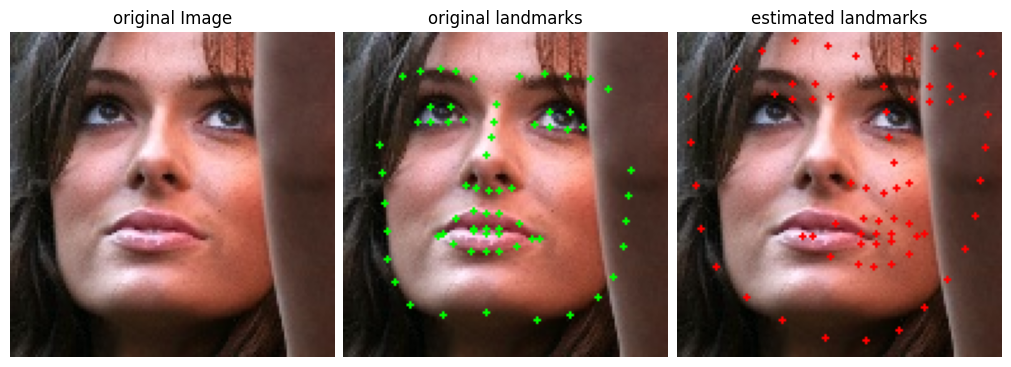

In [ ]:
image_idx=0#np.uint(np.random.uniform(0,1000))

example_image_path= os.path.join(training_data_folder, "resized_image_"+str(image_idx)+".jpg")
example_image_path_reg_train, example_landmarks, perturbations = initialize_and_perturbate(example_image_path, mean_shape)



trial_image=np.ones((1,reduced_features.shape[1]+1))
trial_image[0,:-1]=reduced_features[image_idx]

pred=reg.predict(trial_image)
pred[0]=mean_shape.copy().reshape(136)+pred[0]
pred=pred[0]
pred=pred.reshape((68,2))



fig, axs = plt.subplots(1, 3, figsize=(10, 6), layout='constrained')

axs[0].imshow(example_image_path_reg_train,vmin=0,vmax=255,cmap='gray')
axs[0].axis("off")
axs[0].set_title("original Image")
image_lm=example_image_path_reg_train.copy()
draw_landmarks(image_lm, example_landmarks,size=1)
axs[1].imshow(image_lm,vmin=0,vmax=255,cmap='gray')
axs[1].axis("off")
axs[1].set_title("original landmarks")
image_lm_reg=example_image_path_reg_train.copy()
draw_landmarks(image_lm_reg, pred,size=1,c=(255, 0,0))
axs[2].imshow(image_lm_reg,vmin=0,vmax=255,cmap='gray')
axs[2].axis("off")
axs[2].set_title("estimated landmarks")


### What can we conclude ?

Even if the landmarks generated by our model seems to try to adapt to each faces present to the dataset we can still
see the average face shape in the generated landmarks. This might be due to the fact that our model is only a linear regression.
The use of non linear methods such as multi-layer perceptrons might lead to better results.

### Why this prediction error is not relevant to evaluate our methods ?

The prediction error is not relevant because it is difficult to interpret. The $L_2$ norm could have been better because it is the geometric distance between the prediction and the target. It could have been interesting to use metrics able to feature the orientation of the predicted landmarks. For instance a metric able to detect if the generated landmarks are not on the scale of the target landmarks.

### Compute the prediction error on the test set and display s0 the initial position of the model (in red) and $s_0 + \delta_s$ the displaced landmarks (in green) for the 5 first images of the test set.

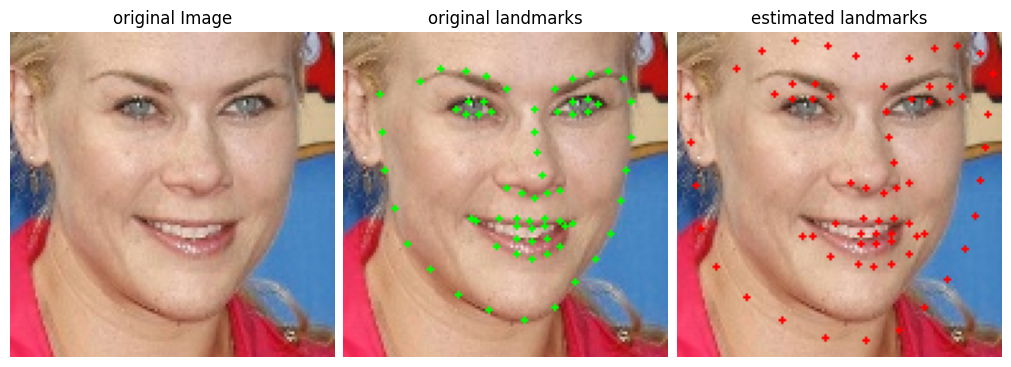

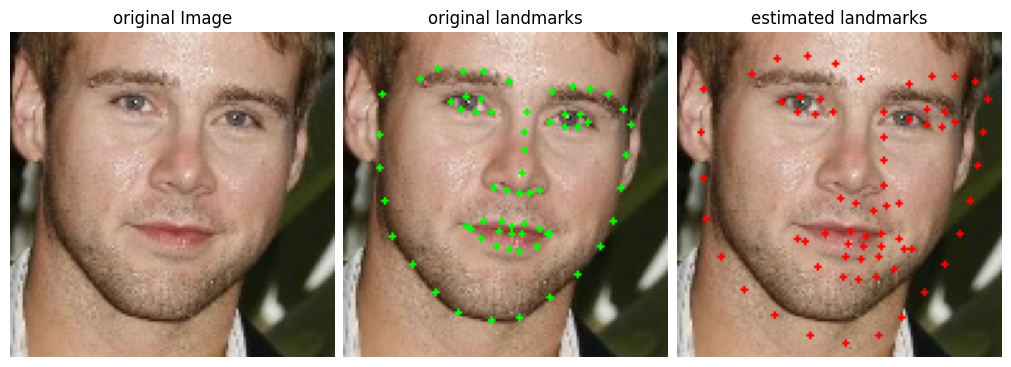

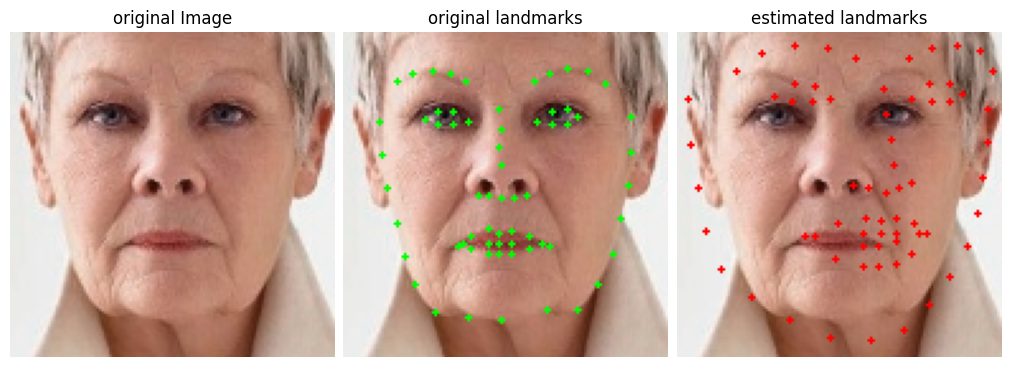

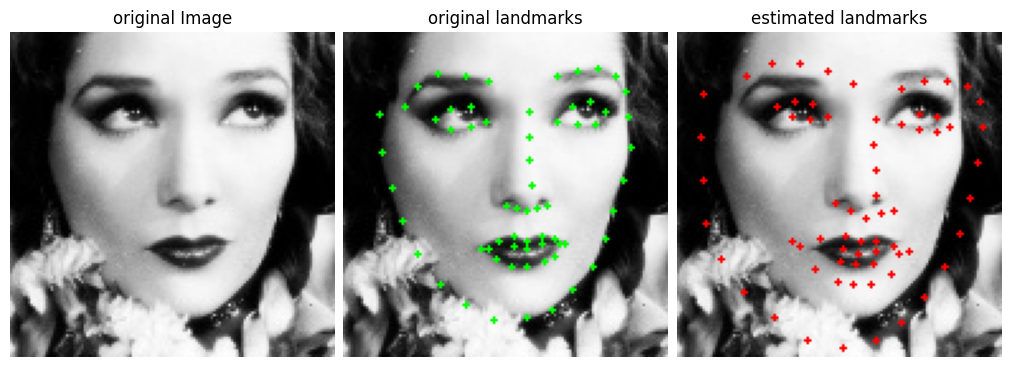

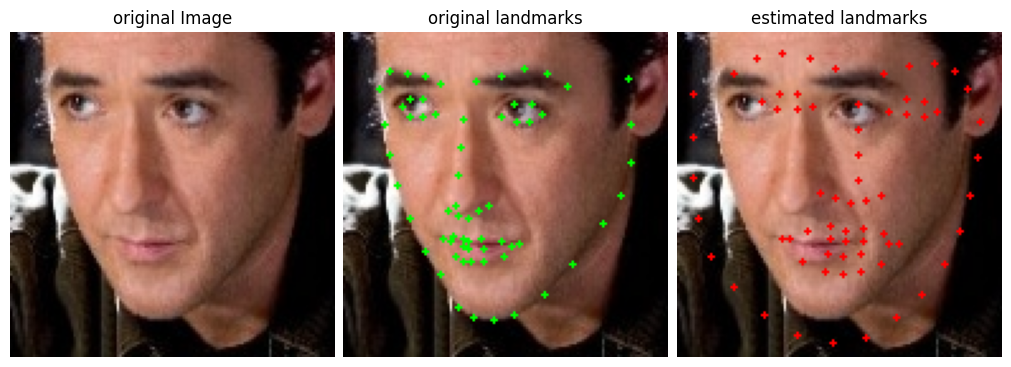

In [ ]:
for image_idx in range(5):
    #=np.uint(np.random.uniform(0,100))
    test_data_folder = "./content/test_images"
    example_image_path= os.path.join(test_data_folder, "resized_image_"+str(image_idx)+".jpg")
    example_image_path_reg_train, example_landmarks, perturbations = initialize_and_perturbate(example_image_path, mean_shape)



    trial_image=np.ones((1,reduced_features.shape[1]+1))
    trial_image[0,:-1]=reduced_features[image_idx]

    pred=reg.predict(trial_image)
    pred[0]=mean_shape.copy().reshape(136)+pred[0]
    pred=pred.reshape((68,2))



    fig, axs = plt.subplots(1, 3, figsize=(10, 6), layout='constrained')

    fond_blanc=np.uint(np.zeros((128,128))*255)
    axs[0].imshow(example_image_path_reg_train,vmin=0,vmax=255,cmap='gray')
    axs[0].axis("off")
    axs[0].set_title("original Image")
    image_lm=example_image_path_reg_train.copy()
    draw_landmarks(image_lm, example_landmarks,size=1)
    axs[1].imshow(image_lm,vmin=0,vmax=255,cmap='gray')
    axs[1].axis("off")
    axs[1].set_title("original landmarks")
    image_lm_reg=example_image_path_reg_train.copy()
    draw_landmarks(image_lm_reg, pred,size=1,c=(255, 0,0))

    error=example_landmarks-example_landmarks
    axs[2].imshow(image_lm_reg,vmin=0,vmax=255,cmap='gray')
    axs[2].axis("off")
    axs[2].set_title("estimated landmarks")


In [ ]:
# Specify the path to your dataset
dataset_path = "./content/test_images"

# Create cv2.KeyPoint objects for each landmark
mean_shape,_ = compute_mean_shape(training_data_folder)
keypoints = create_keypoints(mean_shape)

# Initialize an array to store concatenated features for all images
all_features_test = []
L_test_landmarks=[]
L_mean_landmarks_test=[]
# Loop through all images in the dataset
for file_name in os.listdir(dataset_path):
    for _ in range(10):
        if file_name.endswith(".jpg"):
            # Read image and landmarks
            image_path = os.path.join(dataset_path, file_name)
            image = cv2.imread(image_path)
            landmarks_path = image_path.replace('.jpg', '.pts')
            landmarks = read_landmarks(landmarks_path)
            L_test_landmarks.append(landmarks)

            # Compute SIFT features around each landmark
            mean_landmarks=perturbate_meanshape(mean_shape, scale_amplitude=0.2, translation_amplitude=20)
            L_mean_landmarks_test.append(mean_landmarks)
            keypoints = create_keypoints(mean_landmarks.copy())
            sift_features = compute_sift_features(image, keypoints)

            # Concatenate the features for this image

            concatenated_features = sift_features.flatten()

            # Add the concatenated features to the array
            all_features_test.append(concatenated_features)


# Convert the array to a numpy array for further processing
all_features_test = np.array(all_features_test)
reduced_features_test=pca.transform(all_features_test)
L_mean_landmarks_test=np.array(L_mean_landmarks_test)
L_mean_landmarks_test=L_mean_landmarks_test.reshape((L_mean_landmarks_test.shape[0],136))
# Print the shape of the concatenated features array
B_test = np.hstack((reduced_features_test, np.ones((reduced_features_test.shape[0],1))))
test_pred = reg.predict(B_test)

L_test_landmarks=np.array(L_test_landmarks).reshape((reduced_features_test.shape[0],136))

error_abs=(np.abs(L_test_landmarks-L_mean_landmarks_test+test_pred)).mean(axis=1)
print(error_abs.mean())

11.479284382344078


### What can we conclude ?

The method is slightly adapting to each face of the dataset. This might be due to the fact that our model is only a linear regression. The use of non linear methods such as multi-layer perceptrons might lead to better results.

## CONCLUSION

Following this experiment, we successfully deployed the envisioned protocol and obtained results that warrant special attention. A primary observation concerns the mean absolute error, which stands at 11 pixels across the entire test dataset. Although this value might seem low, practice has shown that the predicted landmarks can sometimes be significantly distant from their actual position on faces. This divergence raises questions about the relevance of the metric used.

Indeed, the mean absolute error, while commonly used, here seems to not accurately reflect the real performance of our model. It also proves difficult to interpret in the specific context of our study. Other metrics, such as the L2 norm that measures geometric distance, might have been more appropriate to evaluate our approach.

However, it is important to underline that the moderate performance of our method is not solely attributable to the chosen metric, as it is just a tool for evaluation and interpretation. The inherent limitations of the linearity of PCA and linear regression seem to have played a crucial role in our results. An initial improvement approach could have been the use of nonlinear techniques for data dimensionality reduction. Similarly, replacing linear regression with more sophisticated approaches, such as a multilayer perceptron, could have been considered.

Although this latter solution is more complex to implement, requiring a careful choice of hyperparameters, it has the advantage of enabling End to End training. In other words, it could have facilitated data processing without going through intermediate manual compression steps (via PCA and SIFT) before training another algorithm. This integrated approach could potentially have led to more accurate results and better adaptation to the specificities of our dataset.
